# Movies & Reviews Project. Gestión de sistemas de datos masivos

Este cuaderno es el núcleo del proyecto de Gestión de sistemas de datos masivos. Integra el **data warehouse** desarrollado en Apache Hive, el **data lake** implementado con ElasticSearch y Hadoop, y la ontología que describe la infraestructura montada mediante los datos enlazados en GraphDB. La ontología explota el concepto de **data space** para permitir consultas cruzadas entre diversos conjuntos de datos distribuidos en Internet.

El objetivo principal del proyecto es **analizar las reseñas de películas para identificar las palabras que puedan distinguir entre los grupos de películas, organizados en cuartiles según su puntuación media**.

<div style="border: 1px solid black; padding: 10px; background-color: #f9f9f9;">
    El fichero metadata.md en el directorio ./data describe los conjuntos de datos estructurados, no estructurados y enlazados. En él también se explica la preparación de la infraestructura, desde el punto de vista de los datos en su estado primigenio.
</div>

<br>

**Autores**:
- Rosa López Escalona
- Fernando Fernández Álvarez
- Miguel González García
- Jorge del Castillo Gómez

---

# Conexion a Hive
Se establece la conexión a Hive para extraer el conjunto de películas almacenado en PostgreSQL, ejecutando un JOIN con el dataset de reseñas de películas de Rotten Tomatoes, el cual está guardado en un archivo CSV. La consulta necesaria se lleva a cabo a través de SQLAlchemy.

In [8]:
!pip install pyhive sqlalchemy --quiet
!pip install thrift --quiet
!pip install thrift_sasl --quiet
!pip install sqlalchemy pyhive thrift --quiet

import pandas as pd

La creación de las tablas en Hive se ha completado ejecutando las siguientes consultas SQL en su visualizador. La primera tabla "movies_linked" se enlaza con el conjunto de películas almacenado en PostgreSQL. La tabla "rotten_movies" se enlaza con el conjunto de películas de Rotten Tomatoes, almacenadas en un fichero *.csv*. 

```sql
CREATE EXTERNAL TABLE movies_linked (
    movie_id INT,
    budget FLOAT,
    original_language STRING,
    overview STRING,
    popularity FLOAT,
    release_date DATE,
    revenue FLOAT,
    runtime FLOAT,
    title STRING,
    vote_average FLOAT,
    vote_count INT,
    release_year INT,
    retorno FLOAT
)
STORED BY 'org.apache.hive.storage.jdbc.JdbcStorageHandler'
TBLPROPERTIES (
  "hive.sql.database.type" = "POSTGRES",
  "hive.sql.jdbc.driver" = "org.postgresql.Driver",
  "hive.sql.jdbc.url" = "jdbc:postgresql://hive4-postgres:5432/postgres",
  "hive.sql.dbcp.username" = "hive",
  "hive.sql.dbcp.password" = "password",
  "hive.sql.table" = "movies"
);

CREATE EXTERNAL TABLE rotten_movies (
  rotten_tomatoes_link STRING,
  movie_title STRING,
  movie_info STRING, 
  critics_consensus INT,
  content_rating STRING,
  genres STRING,
  directors INT,
  authors INT,
  actors INT,
  original_release_date STRING,
  streaming_release_date STRING,
  runtime INT,
  production_company INT,
  tomatometer_status INT,
  tomatometer_rating INT,
  tomatometer_count INT,
  audience_status INT,
  audience_rating INT,
  audience_count INT,
  tomatometer_top_critics_count INT,
  tomatometer_fresh_critics_count INT,
  tomatometer_rotten_critics_count INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/opt/hive/data/warehouse/rotten_movies';

LOAD DATA LOCAL INPATH '/opt/hive/data/warehouse/rotten_tomatoes_movies.csv' INTO TABLE rotten_movies;
```

> Una vez creadas las tablas, se ejecuta una consulta **JOIN** entre las películas almacenadas en PostgreSQL y las del fichero .csv. 

In [1]:
# representa la conexión entre la aplicación y la base de datos
from sqlalchemy import create_engine
import pandas as pd

# Conexión usando SQLAlchemy
engine = create_engine('hive://hiveserver2:10000/default')
'hive://localhost:10000/default'

query = """
SELECT
    r.movie_title,
    m.original_language,
    m.budget,
    m.release_date,
    m.revenue,
    m.runtime,
    m.retorno,
    m.vote_average,
    m.vote_count,
    r.content_rating,
    r.directors,
    r.authors,
    r.actors,
    r.production_company,
    r.tomatometer_rating,
    r.tomatometer_count
    
    
FROM
    default.movies_linked m
INNER JOIN
    default.rotten_movies r
ON
    m.title = r.movie_title
"""

# Ejecuta la consulta y guarda el resultado en un DataFrame
df = pd.read_sql(query, engine)

# Imprime el DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15492 entries, 0 to 15491
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_title         15492 non-null  object 
 1   original_language   15492 non-null  object 
 2   budget              15492 non-null  float64
 3   release_date        15492 non-null  object 
 4   revenue             15492 non-null  float64
 5   runtime             15488 non-null  float64
 6   retorno             15492 non-null  float64
 7   vote_average        15492 non-null  float64
 8   vote_count          15492 non-null  int64  
 9   content_rating      15492 non-null  object 
 10  directors           15492 non-null  object 
 11  authors             15492 non-null  object 
 12  actors              15492 non-null  object 
 13  production_company  15492 non-null  object 
 14  tomatometer_rating  15473 non-null  float64
 15  tomatometer_count   15473 non-null  float64
dtypes: f

In [2]:
df.head(5)

,movie_title,original_language,budget,release_date,revenue,runtime,retorno,vote_average,vote_count,content_rating,directors,authors,actors,production_company,tomatometer_rating,tomatometer_count
0,Toy Story,en,30000000.0,1995-10-30,373554048.0,81.0,12.451801,7.7,5415,G,John Lasseter,"Joss Whedon, Andrew Stanton, Joel Cohen, Alec ...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",Buena Vista,100.0,90.0
1,Jumanji,en,65000000.0,1995-12-15,262797248.0,104.0,4.043035,6.9,2413,PG,Joe Johnston,"Jonathan Hensleigh, Chris Van Allsburg, Jim St...","Robin Williams, Bonnie Hunt, Kirsten Dunst, Br...",Sony Pictures Home Entertainment,55.0,38.0
2,Grumpier Old Men,en,0.0,1995-12-22,0.0,101.0,0.000000,6.5,92,PG-13,Howard Deutch,Mark Steven Johnson,"Jack Lemmon, Walter Matthau, Ann-Margret, Soph...",Warner Home Video,17.0,18.0
3,Waiting to Exhale,en,16000000.0,1995-12-22,81452160.0,127.0,5.090760,6.1,34,R,Forest Whitaker,"Terry McMillan, Ronald Bass","Whitney Houston, Angela Bassett, Lela Rochon, ...",Twentieth Century Fox Home Entertainment,56.0,27.0
4,Tom and Huck,en,0.0,1995-12-22,0.0,97.0,0.000000,5.4,45,PG,Peter Hewitt,"Stephen Sommers, David Loughery, Ron Koslow","Jonathan Taylor Thomas, Brad Renfro, Eric Schw...",Buena Vista,25.0,8.0


> En este punto, se disponen de 15.000 películas con la mezcla de atributos de dos datasets estructurados de películas. El siguiente paso es distribuir las películas en cuartiles [Q1,Q2,Q3,Q4] en base a la puntuación media "vote_average" y la puntuación de rotten tomatoes "tomatometer_rating".

In [3]:
### Distribución en quartiles de las 15.492 películas en base a su vote_average, puntuación de tomatometer_rating
df['quartile_vc'] = pd.qcut(df['vote_average'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['quartile_rotten_rating'] = pd.qcut(df['tomatometer_rating'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

print(df[['movie_title', 'vote_average', 'quartile_vc', 'quartile_rotten_rating']].head(15))

               movie_title  vote_average quartile_vc quartile_rotten_rating
0                Toy Story           7.7          Q4                     Q4
1                  Jumanji           6.9          Q4                     Q2
2         Grumpier Old Men           6.5          Q3                     Q1
3        Waiting to Exhale           6.1          Q2                     Q2
4             Tom and Huck           5.4          Q1                     Q1
5             Sudden Death           5.5          Q1                     Q2
6                GoldenEye           6.6          Q3                     Q3
7   The American President           6.5          Q3                     Q4
8                    Balto           7.1          Q4                     Q2
9                    Nixon           7.1          Q4                     Q3
10        Cutthroat Island           5.7          Q2                     Q2
11                  Casino           7.8          Q4                     Q3
12          

## Obtencion de los identificadores de las peliculas 
El objetivo de este apartado es recuperar los identificadores de las 15.000 películas a través de SparQL. Para ello, se realiza una consulta a la ontología de Wikidata, a través de su endpoint, para obtener los identificadores de las películas y poder obtener posteriormente las reseñas de esas películas por medio de **Webscraping** de las URl: https://www.imdb.com/title/{identificadores}/reviews/_ajax

> Un ejemplo práctico: a partir del título de la película "Toy Story", se realiza una consulta SparQL para recuperar su identificador 'tt0114709'. En siguiente paso es concatenar el identificador en la URL de IMDB: https://www.imdb.com/title/tt0114709/reviews/_ajax. Mediante webscraping, se obtienen las 25 reviews asociadas a "Toy Story".

La obtención de los identificadores se realiza con consultas de batches de 200 títulos de películas, acelerando la tarea en cuestión.

In [5]:
len(df['movie_title'])

15492

In [6]:
import requests

def get_imdb_ids(titles):
    # Se concatenan los titulos con un formato legible por SparQL
    titles_str = ' '.join([f'"{title}"@en' for title in titles])
    
    # Consulta SparQL para obtener el ID de IMDb
    query = f"""
    SELECT ?item ?itemLabel ?imdb_id
    WHERE {{
      VALUES ?title {{ {titles_str} }}
      ?item rdfs:label ?title.
      ?item wdt:P31 wd:Q11424.  # La entidad debe ser una película
      ?item wdt:P345 ?imdb_id.  # ID de IMDb
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    # Endpoint de Wikidata para sparql
    url = "https://query.wikidata.org/sparql"
    headers = {
        'User-Agent': 'Mozilla/5.0'
    }
    params = {
        'format': 'json',
        'query': query
    }
    
    response = requests.get(url, headers=headers, params=params)
    imdb_ids = {}
    
    if response.status_code == 200:
        data = response.json()
        # Se accede a los campos resultado de la consulta SPARQL
        for result in data['results']['bindings']:
            title = result['itemLabel']['value']
            imdb_id = result['imdb_id']['value']
            imdb_ids[title] = imdb_id

        # Para aquellos títulos no encontrados, se rellenan con None
        for title in titles:
            if title not in imdb_ids:
                imdb_ids[title] = None
        
        # Se imprimen los títulos encontrados, devueltos por la consulta
        print(f"Lote de {len(titles)} títulos, encontrados: {len(imdb_ids)}")
        return imdb_ids
    else:
        print("Error:", response.status_code, response.text)


def get_imdb_ids_in_batches(titles, batch_size=200):
    all_imdb_ids = {}
    processed_count = 0  # Contador de títulos procesados

    for i in range(0, len(titles), batch_size):
        batch_titles = titles[i:i + batch_size]
        batch_imdb_ids = get_imdb_ids(batch_titles)
        all_imdb_ids.update(batch_imdb_ids)
        
        processed_count += len(batch_titles)
        print(f"Títulos procesados hasta ahora: {processed_count}")

    return all_imdb_ids

titles = df['movie_title'].tolist()
imdb_ids = get_imdb_ids_in_batches(titles)

print(f"Total de títulos procesados en el diccionario: {len(imdb_ids)}")

Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 200
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 400
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 600
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 800
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 1000
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 1200
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 1400
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 1600
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 1800
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 2000
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 2200
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 2400
Lote de 200 títulos, encontrados: 200
Títulos procesados hasta ahora: 2600
Lote de 200 títulos, encontra

In [8]:
import json

with open('wikidata_ids.json', 'w') as f:
        json.dump(imdb_ids, f, indent=4) 

In [15]:
imdb_ids['Toy Story']

'tt0114709'

## Obtención de reseñas de películas mediante webscraping de IMDB a partir de los identificadores previos

Una vez recuperados los identificadores de 11.906 películas de las 15.492 totales, resultates del JOIN del conjunto estructurado, la siguiente tarea consiste en obtener el dataset de reseñas mediante **WebScraping** y almacenarlo en una infraestructura de ElasticSearch-Hadoop formando un **data lake**.

> *El siguiente código de webscraping es el mismo que se utilizó en la fase de adquisición de datos no estructurados* ./data/unstructured/

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def extract_imdb_reviews(imdb_id):
    # Construir la URL
    url = f"https://www.imdb.com/title/{imdb_id}/reviews/_ajax"
    
    # Enviar la solicitud
    response = requests.get(url)

    # Verificar si la solicitud fue exitosa
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = soup.find_all('div', class_='review-container')

        reviews = []
        for container in review_containers:
            review_text = container.find('div', class_='text show-more__control').text.strip()
            reviews.append(review_text)

        return reviews
    else:
        print(f"Failed to retrieve the page for IMDB ID {imdb_id}. Status code: {response.status_code}")
        return []

def load_existing_reviews(csv_file):
    """Carga las reseñas ya guardadas en el CSV para evitar duplicados"""
    try:
        existing_df = pd.read_csv(csv_file, index_col='imdb_id')
        processed_ids = set(existing_df.index)
        print(f"Loaded {len(processed_ids)} already processed IMDb IDs.")
    except FileNotFoundError:
        existing_df = pd.DataFrame(columns=['imdb_id', 'movie_title', 'review'])
        processed_ids = set()
        print("No existing CSV file found. Starting from scratch.")
    
    return existing_df, processed_ids

def process_reviews_in_batches(imdb_ids, batch_size, csv_file):
    # Se cargan las reseñas recuperadas de batches anteriores
    existing_df, processed_ids = load_existing_reviews(csv_file)
    
    reviews_data = []
    for i, (movie_title, imdb_id) in enumerate(imdb_ids.items()):
        # Saltar si ya fue procesado
        if imdb_id in processed_ids:
            continue

        # Progreso
        print(f"\rProcessing movie {i + 1}: {movie_title}", end="")

        # Obtencion de reseñas para el IMDb ID actual
        reviews = extract_imdb_reviews(imdb_id)
        for review in reviews:
            reviews_data.append({'imdb_id': imdb_id, 'movie_title': movie_title, 'review': review})

        # Guardado y limpieza de identificadores
        if (i + 1) % batch_size == 0 or (i + 1) == len(imdb_ids):
            temp_df = pd.DataFrame(reviews_data)
            temp_df.set_index('imdb_id', inplace=True)
            
            # Se guardan los identificadores en el csv temporal
            reviews_df = pd.concat([existing_df, temp_df], ignore_index=False).drop_duplicates()
            reviews_df.to_csv(csv_file)
            
            print(f"\nSaved {len(reviews_data)} new reviews. Total reviews in CSV: {len(reviews_df)}")

            # Se limpia la lista para el próximo lote
            reviews_data.clear()
            existing_df = reviews_df  # Actualizar el DF existente

            time.sleep(2)

# Configuración
csv_file = 'reviews.csv'
batch_size = 500

# Llamar a la función con el diccionario de IMDb IDs
process_reviews_in_batches(imdb_ids, batch_size, csv_file)

No existing CSV file found. Starting from scratch.
Processing movie 192: BaltoFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 193: Anne Frank RememberedFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 194: Die Hard: With a VengeanceFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 195: A Goofy MovieFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 196: Gumby: The MovieFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 197: The Jerky BoysFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 198: L'EnferFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 199: Mary Shelley's FrankensteinFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 200: The Swan PrincessFailed to retrieve the page for IMDB ID None. Status code: 404
Processing movie 395: The House of the

> Aclaración: Se carga el fichero reviews_f.csv, el cuál almacena las reviews junto con el identificador y título de la película. En total, se disponen de 217.000. reviews. Se ha realizado una modificación intermedia sobre las columnas del .csv que almacenaba los identificadores obtenidos en el bloque de código previo, sustituyendo la columna "Unnamed: 0" por "imdb_id", resultando en la versión del csv final "reviews_f.csv". *El código de la modificación no se incluye en el cuaderno*

In [85]:
df_reviews = pd.read_csv('./reviews_f.csv')

In [86]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217232 entries, 0 to 217231
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   imdb_id      217232 non-null  object
 1   movie_title  217232 non-null  object
 2   review       217232 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [87]:
df_reviews.head(5)

,imdb_id,movie_title,review
0,tt0112715,Congo,"In Congo, Charles Travis (Bruce Campbell) is t..."
1,tt0112715,Congo,"OK, this movie is best watched on a rainy day ..."
2,tt0112715,Congo,A megalomaniac C.E.O. sends his son into the d...
3,tt0112715,Congo,"What can you say about a movie like ""Congo""? W..."
4,tt0112715,Congo,Congo is the first movie on the IMDB for which...


# Conexión a ElasticSearch-Hadoop

En esta segunda fase, se procesan las reseñas recuperadas en la tarea anterior con el objetivo de crear un **data lake** utilizando ElasticSearch-Hadoop.

La principal ventaja de usar Spark con Elasticsearch es su capacidad para procesar grandes volúmenes de datos de forma distribuida y escalable. No se ha configurado un clúster de Spark con Elasticsearch, ya que el entorno actual se ejecuta en una sola máquina. No obstante, en un sistema distribuido, esta integración será fundamental para acelerar los procesos de preprocesamiento y consultas.

In [13]:
from elasticsearch import Elasticsearch
# Se establece la conexion con ElasticSearch
es = Elasticsearch ("http://elasticsearch:9200")

> Se crea el índice "reviews_extracted" para las reviews

In [145]:
if not es.indices.exists(index="reviews_extracted"):
    es.indices.create(index="reviews_extracted")
    print("Índice reviews_extracted creado.")
else:
    print("El índice reviews_extracted ya existe.")

Índice reviews_extracted creado.


### Preprocesado de las reviews

> Se inicia un **preprocesado** sencillo; se eliminan las stopwords de las reviews y se transforman a un formato en minúscula

In [89]:
import re
def clean_text(text):
    
    text = text.lower()
    # Se elimina la puntuacion
    text = re.sub(r'[^\w\s]', '', text)
    # Se eliminan los espacios sobrantes en blanco
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_reviews['review'] = df_reviews['review'].apply(clean_text)

In [90]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df_reviews['review'] = df_reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

> Sobre el dataframe "df_review_cleaned", a continuación se añaden dos columnas asociadas a los cuartiles que se habían generado en el dataset estructurado extraído del Hive al comienzo del notebook. De esta forma, cada review insertada en elasticsearch tendrá asociada sus respectivos cuartiles sobre la puntuación media y la puntuación de rotten tomatoes.

``` python
### Distribución en quartiles de las 15.492 películas en base a su vote_average, puntuación de tomatometer_rating y budget
df['quartile_vc'] = pd.qcut(df['vote_average'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['quartile_rotten_rating'] = pd.qcut(df['tomatometer_rating'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

print(df[['movie_title', 'vote_average', 'quartile_vc', 'quartile_rotten_rating']].head(5))  ```

In [91]:
# Se realiza un merge entre el dataframe df que contiene las películas procesadas en su estado final y el dataframe de reviews, por medio del campo "title"
# Elimino duplicados en df para la columna movie_title, manteniendo una sola fila por película
df_unique = df[['movie_title', 'quartile_vc', 'quartile_rotten_rating']].drop_duplicates(subset='movie_title')

df_reviews = df_reviews.merge(df_unique, on='movie_title', how='left')

In [92]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217232 entries, 0 to 217231
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   imdb_id                 217232 non-null  object  
 1   movie_title             217232 non-null  object  
 2   review                  217232 non-null  object  
 3   quartile_vc             217232 non-null  category
 4   quartile_rotten_rating  216981 non-null  category
dtypes: category(2), object(3)
memory usage: 5.4+ MB


In [93]:
df_reviews.head(5)

,imdb_id,movie_title,review,quartile_vc,quartile_rotten_rating
0,tt0112715,Congo,congo charles travis bruce campbell testing co...,Q1,Q1
1,tt0112715,Congo,ok movie best watched rainy day youre pretty b...,Q1,Q1
2,tt0112715,Congo,megalomaniac ceo sends son dangerous african c...,Q1,Q1
3,tt0112715,Congo,say movie like congo well silly underdeveloped...,Q1,Q1
4,tt0112715,Congo,congo first movie imdb writing user comment gi...,Q1,Q1


> Se muestran el número de reviews que pertenencen a cada cuartil.
> <br>
<br>*Recordatorio: los cuartiles se han generado a partir de los atributos "vote_average" y "tomatometer_rating" de las películas. Si "Toy Story" pertenece al cuartil "Q1", sus 25 reviews pertenecen al mismo cuartil.*

In [132]:
### Conteo de cuartiles 
print(df_reviews['quartile_vc'].value_counts())
print(df_reviews['quartile_rotten_rating'].value_counts())

quartile_vc
Q2    59158
Q3    55646
Q4    51443
Q1    50985
Name: count, dtype: int64
quartile_rotten_rating
Q3    56528
Q2    55931
Q1    55733
Q4    48789
Name: count, dtype: int64


### Inserción en ElasticSearch

> Se inicia el proceso de inserción de las reviews en ElasticSearch.
> Un documento de review contiene los siguientes campos:
> - imdb_id: identificador de la película en IMDB.
> - movie_title: título de la película.
> - quartile_vc: cuartil de la puntuación media al que pertenece la review.
> - quartile_rotten_rating: cuartil de la puntuación de rotten tomatoes al que pertenece la review.
> - review: contenido de la review.

In [15]:
df_reviews.to_csv('./reviews_to_ES.csv')

In [114]:
from elasticsearch.helpers import bulk

docs = []
columns = df_reviews.columns
for idx, row in df_reviews.iterrows():
    
    tupla = {
        '_index': 'reviews_extracted',
        '_id': idx,
        '_source': {
            columns[0]: row[columns[0]],  # imdb_id
            columns[1]: row[columns[1]],  # movie_title
            columns[3]: str(row[columns[3]]) if row[columns[3]] is not None and not pd.isna(row[columns[3]]) else "", # quartile_vc
            columns[4]: str(row[columns[4]]) if row[columns[4]] is not None and not pd.isna(row[columns[4]]) else "", # quartile_rotten_rating
            columns[2]: row[columns[2]]   # review
        }
    }
    docs.append(tupla)

# Verifica el contenido del segundo documento en la lista
docs[1]

{'_index': 'reviews_extracted',
 '_id': 1,
 '_source': {'imdb_id': 'tt0112715',
  'movie_title': 'Congo',
  'quartile_vc': 'Q1',
  'quartile_rotten_rating': 'Q1',
  'review': 'ok movie best watched rainy day youre pretty bored fake looking gorillas obviously wellmade whereas 1993 film jurassic park familiarized audiences cg dinosaurs fact cgi originally planned grays technology yet developed point realistic hair could created smooth skinned dinosaurs possible hairy apes would looked inappropriately cartooned therefore animatronics masks puppetry utilized kind damper special effects well tim currys bad acting movie could lot better viewable got gorilla puppets tim currys accent pretty decent movie thought story good jurassic park michael crichton congo wasnt realistic neither jurassic park like show legends hidden temple intelligent gorillas science action plot could sit watch ill give barely 6 stars'}}

In [115]:
print(len(docs))

217232


> Los docs de reviews se insertan en batches de 8000.

In [150]:
from elasticsearch.helpers import bulk, BulkIndexError
from itertools import islice

def chunk_data(iterable, size):
    """Divide el iterable en trozos de tamaño `size`."""
    it = iter(iterable)
    for first in it:
        yield [first] + list(islice(it, size - 1))

batch_size = 8000

try:
    for i, batch in enumerate(chunk_data(docs, batch_size)):
        print(f"Lote {i+1}: {len(batch)} documentos")
        res = bulk(es, batch)
        print(f'Inserciones reales: {res}')
except BulkIndexError as e:
    # Muestra cuántos documentos fallaron
    print(f"{len(e.errors)} documentos fallaron al indexar.")
    for error in e.errors:
        # Muestra los detalles de cada error
        print(error)

Lote 1: 8000 documentos
Inserciones reales: (8000, [])
Lote 2: 8000 documentos
Inserciones reales: (8000, [])
Lote 3: 8000 documentos
Inserciones reales: (8000, [])
Lote 4: 8000 documentos
Inserciones reales: (8000, [])
Lote 5: 8000 documentos
Inserciones reales: (8000, [])
Lote 6: 8000 documentos
Inserciones reales: (8000, [])
Lote 7: 8000 documentos
Inserciones reales: (8000, [])
Lote 8: 8000 documentos
Inserciones reales: (8000, [])
Lote 9: 8000 documentos
Inserciones reales: (8000, [])
Lote 10: 8000 documentos
Inserciones reales: (8000, [])
Lote 11: 8000 documentos
Inserciones reales: (8000, [])
Lote 12: 8000 documentos
Inserciones reales: (8000, [])
Lote 13: 8000 documentos
Inserciones reales: (8000, [])
Lote 14: 8000 documentos
Inserciones reales: (8000, [])
Lote 15: 8000 documentos
Inserciones reales: (8000, [])
Lote 16: 8000 documentos
Inserciones reales: (8000, [])
Lote 17: 8000 documentos
Inserciones reales: (8000, [])
Lote 18: 8000 documentos
Inserciones reales: (8000, [])
L

In [151]:
index_name = "reviews_extracted"
try:
    doc_count = es.count(index=index_name)['count']
    print(f"El índice '{index_name}' contiene {doc_count} documentos.")
except Exception as e:
    print(f"Error al obtener el conteo de documentos en el índice '{index_name}': {e}")

El índice 'reviews_extracted' contiene 217232 documentos.


> Se comprueba que la inserción sea exitosa mediante una consulta que devuelva 3 reviews.

In [4]:
response = es.search(index="reviews_extracted", body={
    "query": {
        "match_all": {}  # Esto devuelve todos los documentos, sin ningún filtro específico.
    },
    "size": 3  # Limita la cantidad de documentos devueltos a 3.
})

# Se extraen las reviews (documentos) de la respuesta
reviews = response['hits']['hits']

for i, review in enumerate(reviews):
    print(f"Review {i+1}: {review['_source']['imdb_id']}")

Review 1: tt0112715
Review 2: tt0112715
Review 3: tt0112715


# Casos de uso. Comparación de los tópicos entre cuartiles

La última fase del análisis consiste en extraer los tópicos más relevantes de cada cuartil, utilizando dos distribuciones de películas clasificadas según dos tipos de puntuaciones. Esto nos permitirá identificar coincidencias entre los tópicos de los cuartiles o determinar si algunos son discriminantes específicos para cada rango de puntuación.

El método empleado para extraer los tópicos más importantes es la frecuencia de término **TF-IDF**. 

1. El primer subapartado "Tópicos en base a la Puntuación de rotten tomatoes" describe el proceso llevado a cabo para extraer y comparar los tópicos en base a los cuartiles definidos por el atributo "tomatometer_rating".
2. El segundo subapartado "Tópicos en base a la Puntuación media" describe el proceso en base a los cuartiles definidos por el atributo "vote_average".

In [1]:
from elasticsearch import Elasticsearch
import pandas as pd

# Se establece la conexion con ElasticSearch
es = Elasticsearch ("http://elasticsearch:9200")

## **1º Caso de uso. Análisis de los tópicos más importantes entre el cuartil 'Q1' y 'Q4' a partir de vote_average**
La hipótesis de este caso de uso es identificar los tópicos discriminantes en las reseñas entre el cuartil "Q1" y el cuartil "Q4" de las películas. Las películas clasificadas en **Q1** corresponden a aquellas peor valoradas, mientras que las que pertenecen a **Q4** son las mejor valoradas. La distribución en cuartiles se basa en el atributo `vote_average`.

<center>Recordatorio: Las reseñas de una película que pertenece a Q1 también se identifican dentro de ese cuartil.</center><br>

Para lograr esto, se analizan los **tópicos sustantivos y adjetivos** presentes en las reseñas de ambos cuartiles.


> A continuación, se recuperan las reseñas por los cuartiles de "quartile_vc" y se almacenan en un diccionario. Esta tarea se podría acelerar configurando un cluster en Hadoop con varias máquinas

In [36]:
from elasticsearch import Elasticsearch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import nltk

# Parámetros de scroll 
scroll_time = "1m"  
batch_size = 1000   

def obtener_resenas_por_cuartil(cuartil):
    """
    Función para extraer todas las reseñas de un cuartil específico de Elasticsearch.
    """
    results = []
    # Realiza la primera búsqueda
    response = es.search(
        index="reviews_extracted",
        scroll=scroll_time,
        body={
            "size": batch_size,  # Tamaño de cada lote
            '_source': ['review'],
            "query": {
                "match": {"quartile_vc": cuartil}
            }
        }
    )
    
    # Guarda el scroll_id y los primeros resultados
    scroll_id = response["_scroll_id"]
    results.extend([hit["_source"]["review"] for hit in response["hits"]["hits"]])
    
    # Itera sobre los resultados usando el scroll
    while True:
        response = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
        hits = response["hits"]["hits"]
        
        # Agrega los resultados actuales
        results.extend([hit["_source"]["review"] for hit in hits])
        
        # Verifica si no hay más resultados
        if not hits:
            break

    # Libera el scroll cuando ya no se necesite
    es.clear_scroll(scroll_id=scroll_id)
    return results

In [37]:
cuartiles = ['Q1', 'Q2', 'Q3', 'Q4']
# Almacenamos las reviews en un diccionario con los cuartiles como claves
resenas_por_cuartil = {cuartil: obtener_resenas_por_cuartil(cuartil) for cuartil in cuartiles}

In [38]:
len(resenas_por_cuartil['Q1'])

50985

> Se calculan las puntuaciones de los tokens de cada cuartil mediante **TF-IDF**. Las puntuaciones se almacenan en el formato [word, score] en un diccionario "palabras_relevantes_por_cuartil", donde las claves son los cuartiles.
> <br>
> Por ejemplo: ```palabras_relevantes_por_cuartil = {'Q1': [ ('good', 100.00), ('bad', 32.23), . . . ], 'Q4': [ (), (), . . . ]} ```

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger_eng')
import matplotlib.pyplot as plt

def obtener_palabras_tfidf(textos, num_palabras=30):
    """
    Función para calcular las palabras más relevantes usando TF-IDF.
    """
    vectorizer = TfidfVectorizer()  # Limitamos a las 'num_palabras' más relevantes
    X = vectorizer.fit_transform(textos)
    
    # Obtenemos las palabras más relevantes y sus puntuaciones TF-IDF
    palabras = vectorizer.get_feature_names_out()
    puntuaciones = X.sum(axis=0).A1  # Suma de las puntuaciones de cada palabra en todos los documentos
    palabras_relevantes = [(palabras[i], puntuaciones[i]) for i in range(len(palabras))]
    
    # Ordenamos las palabras por su puntuación TF-IDF en orden descendente
    palabras_relevantes.sort(key=lambda x: x[1], reverse=True)
    return palabras_relevantes

cuartiles_interes = ['Q1', 'Q4']
palabras_relevantes = None
palabras_relevantes_por_cuartil = {}

for cuartil in cuartiles_interes:
    if cuartil in resenas_por_cuartil:
        print(f"\nPalabras más relevantes para el cuartil {cuartil} usando TF-IDF:")
        palabras_relevantes = obtener_palabras_tfidf(resenas_por_cuartil[cuartil])

        palabras_relevantes_por_cuartil[cuartil] = palabras_relevantes
        
        for i, (palabra, puntuacion) in enumerate(palabras_relevantes):
            if i > 10:
                break
            print(f"{palabra}: {puntuacion:.4f}")
    else:
        print(f"\nNo se encontraron reseñas para el cuartil {cuartil}")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!



Palabras más relevantes para el cuartil Q1 usando TF-IDF:
movie: 2339.0229
film: 1801.5976
one: 1161.8347
like: 1110.3164
good: 1061.5859
really: 870.1988
story: 816.6149
would: 771.9162
bad: 760.0083
time: 755.3319
even: 749.3533

Palabras más relevantes para el cuartil Q4 usando TF-IDF:
film: 2031.0607
movie: 1890.1941
one: 1194.2183
like: 976.8988
story: 922.4787
good: 860.3529
great: 775.1206
time: 767.6905
really: 766.6453
see: 735.8023
well: 714.2394


### Análisis de los 10 sustantivos y adjetivos mas frecuentes entre Q1 y Q4

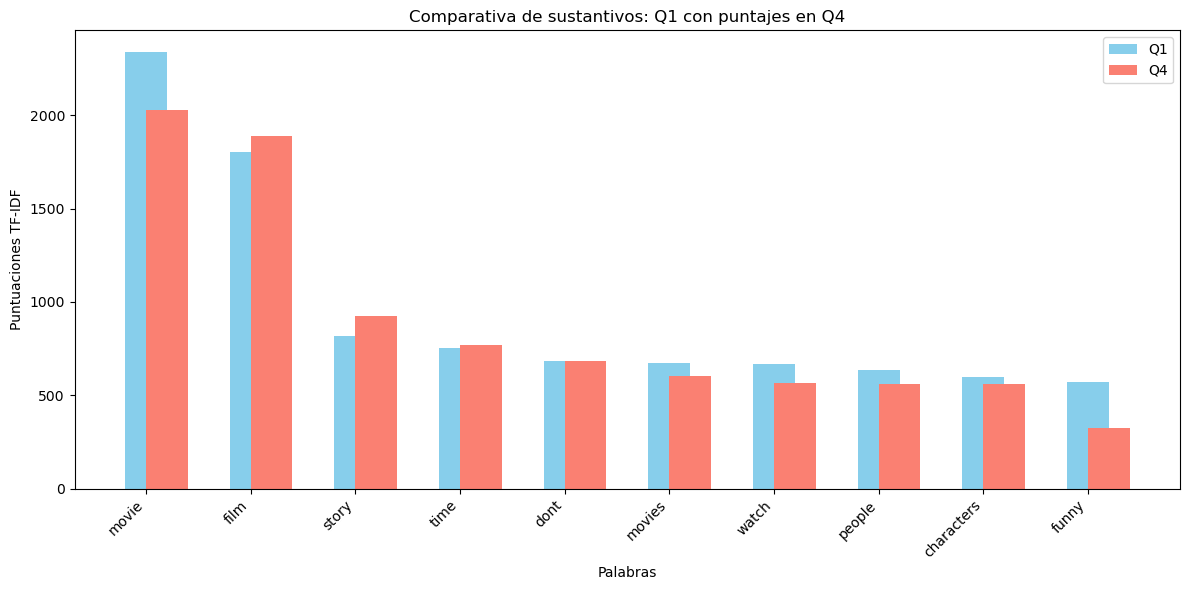

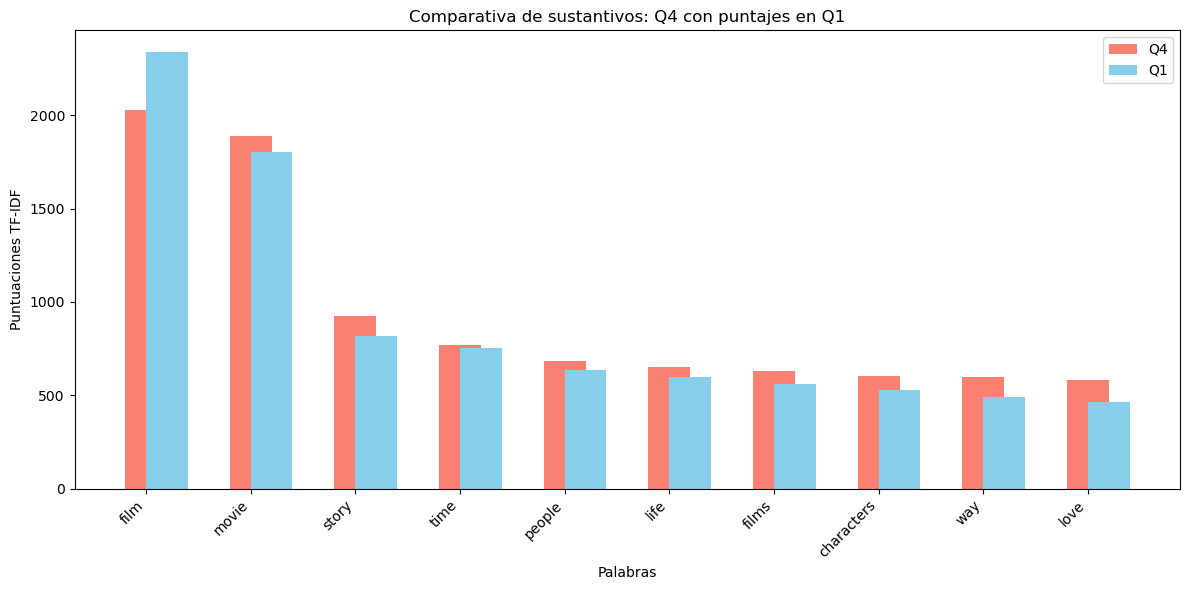

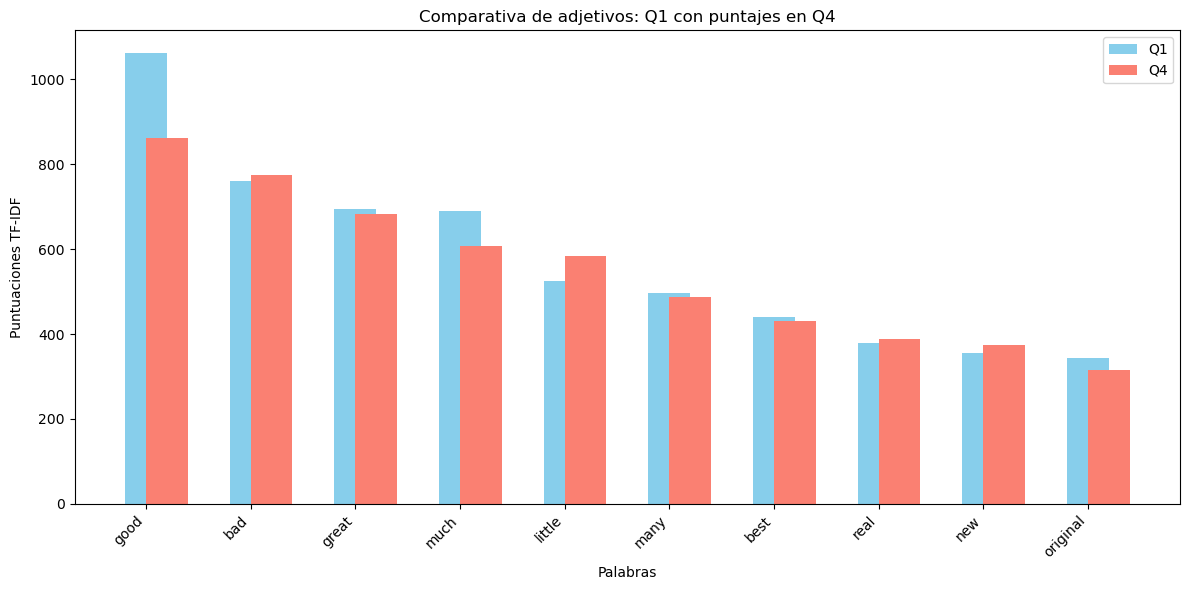

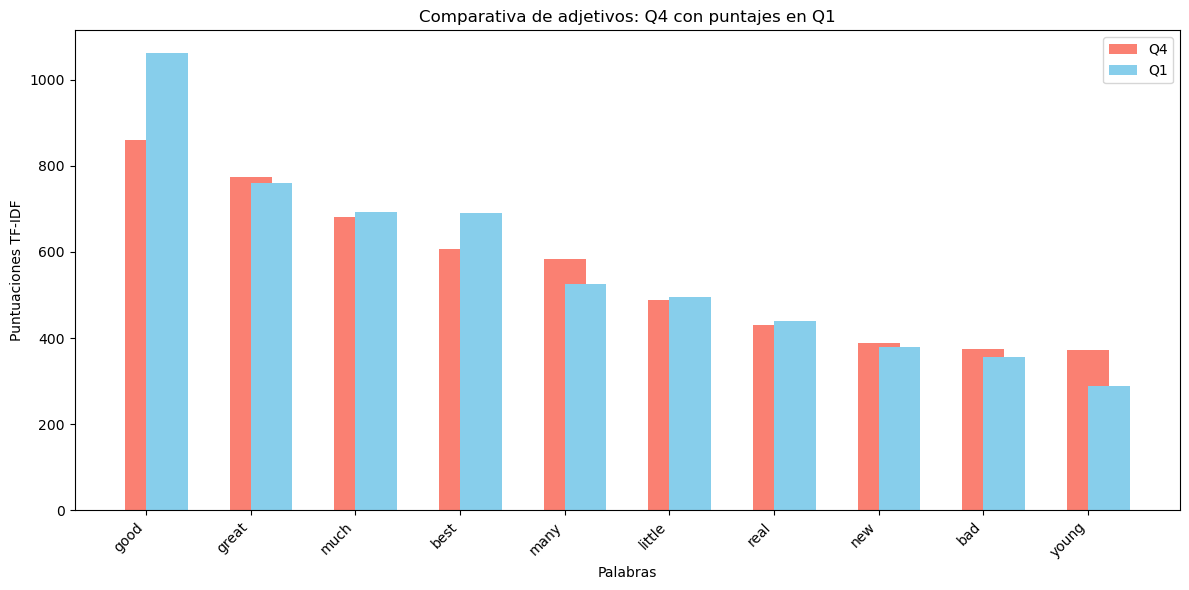

In [40]:
# Esta función filtra las palabras por su tipo: sustantivos o adjetivos
def filtrar_palabras_por_tipo(palabras_relevantes, tipo='NN'):
    """
    Filtra palabras por tipo usando POS tagging.
    - Sustantivos: tipo = 'NN'
    - Adjetivos: tipo = 'JJ'
    """
    return [(word, score) for word, score in palabras_relevantes if pos_tag([word])[0][1].startswith(tipo)]

# Se obtienen las puntuaciones para un conjunto de palabras específico en un cuartil dado
def obtener_puntuaciones_para_palabras(palabras, cuartil, tipo='NN'):
    return [score for word, score in palabras_relevantes_por_cuartil[cuartil] if word in palabras]

# Grafica de comparación de puntuaciones entre dos cuartiles para un tipo de palabras
def graficar_comparativa(palabras, scores1, scores2, cuartil1, cuartil2, titulo, color1, color2):
    plt.figure(figsize=(12, 6))
    x = range(len(palabras))
    plt.bar(x, scores1, width=0.4, label=f'{cuartil1}', align='center', color=color1)
    plt.bar(x, scores2, width=0.4, label=f'{cuartil2}', align='edge', color=color2)
    
    plt.xlabel('Palabras')
    plt.ylabel('Puntuaciones TF-IDF')
    plt.title(titulo)
    plt.xticks(x, palabras, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()




# Parámetros
cuartiles_interes = ['Q1', 'Q4']
num_palabras = 10

colores_cuartiles = ['skyblue', 'salmon', 'lightgreen', 'lightcoral']  # Añadir más colores si tienes más cuartiles

# Filtro de palabras relevantes para Q1 y Q4
palabras_relevantes_sustantivos_Q1 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q1'], 'NN')
palabras_relevantes_sustantivos_Q4 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q4'], 'NN')
palabras_relevantes_adjetivos_Q1 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q1'], 'JJ')
palabras_relevantes_adjetivos_Q4 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q4'], 'JJ')

# Generacion de comparativas para sustantivos y adjetivos
for palabras_relevantes, cuartil_base, cuartil_comp, tipo, titulo in [
    (palabras_relevantes_sustantivos_Q1[:num_palabras], 'Q1', 'Q4', 'sustantivos', 'Comparativa de sustantivos: Q1 con puntajes en Q4'),
    (palabras_relevantes_sustantivos_Q4[:num_palabras], 'Q4', 'Q1', 'sustantivos', 'Comparativa de sustantivos: Q4 con puntajes en Q1'),
    (palabras_relevantes_adjetivos_Q1[:num_palabras], 'Q1', 'Q4', 'adjetivos', 'Comparativa de adjetivos: Q1 con puntajes en Q4'),
    (palabras_relevantes_adjetivos_Q4[:num_palabras], 'Q4', 'Q1', 'adjetivos', 'Comparativa de adjetivos: Q4 con puntajes en Q1')
    ]:
    
    palabras = [word for word, score in palabras_relevantes]
    scores_base = [score for word, score in palabras_relevantes]
    scores_comp = obtener_puntuaciones_para_palabras(palabras, cuartil_comp, tipo)

    # Se asignan colores unicos a cada cuartil
    color_base = colores_cuartiles[cuartiles_interes.index(cuartil_base)] 
    color_comp = colores_cuartiles[cuartiles_interes.index(cuartil_comp)] 
    
    graficar_comparativa(palabras, scores_base, scores_comp, cuartil_base, cuartil_comp, titulo, color_base, color_comp)

### Análisis de los 10 sustantivos y adjetivos más discriminantes entre Q1 y Q4

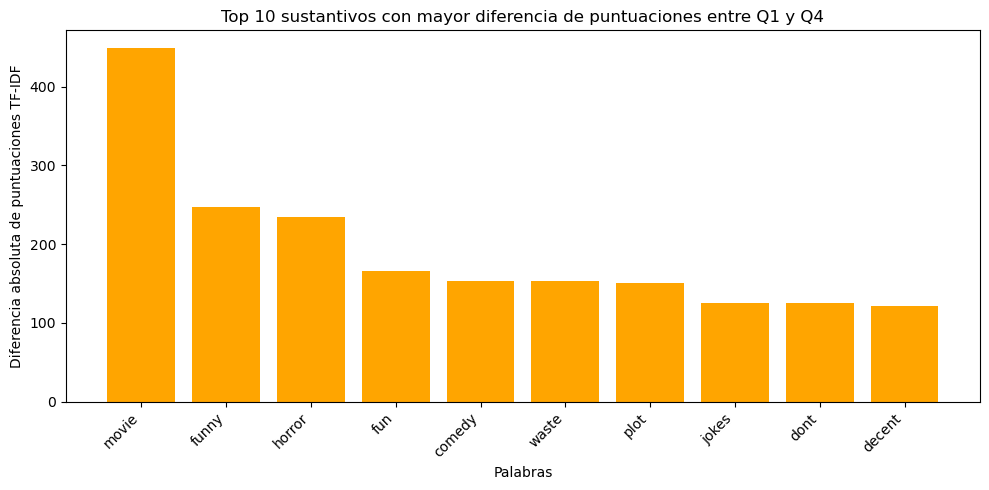

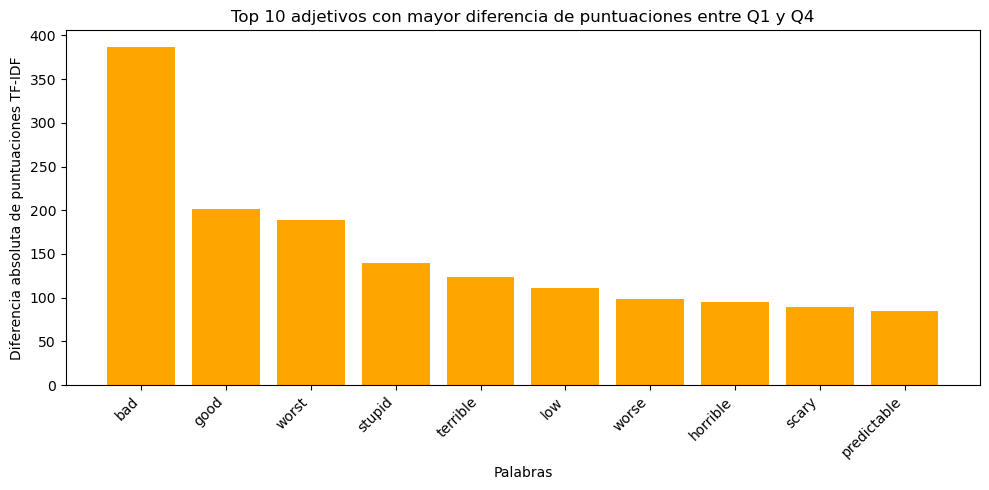

In [41]:
import numpy as np

def obtener_palabras_con_mayor_diferencia(palabras_relevantes_Q1, palabras_relevantes_Q4):
    """
    Calcula las diferencias de puntuación entre palabras en Q1 y Q4 y selecciona las 10 con mayor diferencia.
    """
    # Diccionarios para acceder rápidamente a las puntuaciones de cada palabra
    puntuaciones_Q1 = {word: score for word, score in palabras_relevantes_Q1}
    puntuaciones_Q4 = {word: score for word, score in palabras_relevantes_Q4}
    
    # Intersección de palabras entre Q1 y Q4
    palabras_comunes = set(puntuaciones_Q1.keys()).intersection(set(puntuaciones_Q4.keys()))
    
    # Calcula la diferencia absoluta de puntuaciones y guarda en una lista
    diferencias = [(palabra, puntuaciones_Q1[palabra] - puntuaciones_Q4[palabra]) for palabra in palabras_comunes]
    
    # Ordena por diferencia en orden descendente
    diferencias.sort(key=lambda x: x[1], reverse=True)
    
    # Selecciona las 10 palabras con mayor diferencia
    palabras_mayor_diferencia = diferencias[:10]
    return palabras_mayor_diferencia

# Obtenemos las palabras con mayor diferencia para sustantivos y adjetivos
palabras_mayor_diferencia_sustantivos = obtener_palabras_con_mayor_diferencia(
    palabras_relevantes_sustantivos_Q1, palabras_relevantes_sustantivos_Q4
)
palabras_mayor_diferencia_adjetivos = obtener_palabras_con_mayor_diferencia(
    palabras_relevantes_adjetivos_Q1, palabras_relevantes_adjetivos_Q4
)

# Extraemos palabras y diferencias para graficar
def graficar_diferencias_palabras(palabras_diferencias, tipo_palabra):
    palabras = [word for word, diff in palabras_diferencias]
    diferencias = [diff for word, diff in palabras_diferencias]
    
    plt.figure(figsize=(10, 5))
    plt.bar(palabras, diferencias, color='orange')
    plt.xlabel('Palabras')
    plt.ylabel('Diferencia absoluta de puntuaciones TF-IDF')
    plt.title(f'Top 10 {tipo_palabra} con mayor diferencia de puntuaciones entre Q1 y Q4')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Graficamos las diferencias para sustantivos y adjetivos
graficar_diferencias_palabras(palabras_mayor_diferencia_sustantivos, 'sustantivos')
graficar_diferencias_palabras(palabras_mayor_diferencia_adjetivos, 'adjetivos')

## **2º Caso de uso. Análisis de los tópicos más importantes entre el cuartil 'Q1' y 'Q4' a partir de tomatometer_rating** **balanceado**
La hipótesis de este caso de uso es identificar los tópicos discriminantes en las reseñas entre el cuartil "Q1" y el cuartil "Q4" de las películas. Las películas clasificadas en **Q1** corresponden a aquellas peor valoradas, mientras que las que pertenecen a **Q4** son las mejor valoradas. La distribución en cuartiles se basa en el atributo `tomatometer_rating`.

<center>Recordatorio: Las reseñas de una película que pertenece a Q1 también se identifican dentro de ese cuartil.</center><br>

Para lograr esto, se analizan los **tópicos sustantivos y adjetivos** presentes en las reseñas de ambos cuartiles.


> A continuación, se recuperan las reseñas por los cuartiles de "quartile_rotten_rating" y se almacenan en un diccionario. Esta tarea se podría acelerar configurando un cluster en Hadoop con varias máquinas

In [15]:
from elasticsearch import Elasticsearch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import nltk

# Parámetros de scroll 
scroll_time = "1m"  
batch_size = 1000   

def obtener_resenas_por_cuartil(cuartil):
    """
    Función para extraer todas las reseñas de un cuartil específico de Elasticsearch.
    """
    results = []
    # Realiza la primera búsqueda
    response = es.search(
        index="reviews_extracted",
        scroll=scroll_time,
        body={
            "size": batch_size,  # Tamaño de cada lote
            '_source': ['review'],
            "query": {
                "match": {"quartile_rotten_rating": cuartil}
            }
        }
    )
    
    # Guarda el scroll_id y los primeros resultados
    scroll_id = response["_scroll_id"]
    results.extend([hit["_source"]["review"] for hit in response["hits"]["hits"]])
    
    # Itera sobre los resultados usando el scroll
    while True:
        response = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
        hits = response["hits"]["hits"]
        
        # Agrega los resultados actuales
        results.extend([hit["_source"]["review"] for hit in hits])
        
        # Verifica si no hay más resultados
        if not hits:
            break

    # Libera el scroll cuando ya no se necesite
    es.clear_scroll(scroll_id=scroll_id)
    return results

In [16]:
cuartiles = ['Q1', 'Q2', 'Q3', 'Q4']
# Almacenamos las reviews en un diccionario con los cuartiles como claves
resenas_por_cuartil = {cuartil: obtener_resenas_por_cuartil(cuartil) for cuartil in cuartiles}

In [17]:
len(resenas_por_cuartil['Q1'])

55733

In [18]:
len(resenas_por_cuartil['Q4'])

48789

> Existe una discrepancia en el tamaño de reseñas del primer y cuarto cuartil, por tanto se balancean los cuartiles objetivo de análisis.

In [19]:
# Número de reseñas en cada cuartil de interés
num_resenas_q1 = len(resenas_por_cuartil['Q1'])
num_resenas_q4 = len(resenas_por_cuartil['Q4'])

# Determinamos el número objetivo de reseñas (el mínimo entre Q1 y Q4)
num_resenas_objetivo = min(num_resenas_q1, num_resenas_q4)

# Equilibrar Q1
if num_resenas_q1 > num_resenas_objetivo:
    resenas_por_cuartil['Q1'] = random.sample(resenas_por_cuartil['Q1'], num_resenas_objetivo)

# Equilibrar Q4
if num_resenas_q4 > num_resenas_objetivo:
    resenas_por_cuartil['Q4'] = random.sample(resenas_por_cuartil['Q4'], num_resenas_objetivo)

In [20]:
len(resenas_por_cuartil['Q1'])

48789

In [21]:
len(resenas_por_cuartil['Q4'])

48789

> Se calculan las puntuaciones de los tokens de cada cuartil mediante **TF-IDF**. Las puntuaciones se almacenan en el formato [word, score] en un diccionario "palabras_relevantes_por_cuartil", donde las claves son los cuartiles.
> <br>
> Por ejemplo: ```palabras_relevantes_por_cuartil = {'Q1': [ ('good', 100.00), ('bad', 32.23), . . . ], 'Q4': [ (), (), . . . ]} ```

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk import pos_tag
import nltk
import matplotlib.pyplot as plt

def obtener_palabras_tfidf(textos, num_palabras=30):
    """
    Función para calcular las palabras más relevantes usando TF-IDF.
    """
    vectorizer = TfidfVectorizer()  # Limitamos a las 'num_palabras' más relevantes
    X = vectorizer.fit_transform(textos)
    
    # Obtenemos las palabras más relevantes y sus puntuaciones TF-IDF
    palabras = vectorizer.get_feature_names_out()
    puntuaciones = X.sum(axis=0).A1  # Suma de las puntuaciones de cada palabra en todos los documentos
    palabras_relevantes = [(palabras[i], puntuaciones[i]) for i in range(len(palabras))]
    
    # Ordenamos las palabras por su puntuación TF-IDF en orden descendente
    palabras_relevantes.sort(key=lambda x: x[1], reverse=True)
    return palabras_relevantes

cuartiles_interes = ['Q1', 'Q4']
palabras_relevantes = None
palabras_relevantes_por_cuartil = {}

for cuartil in cuartiles_interes:
    if cuartil in resenas_por_cuartil:
        print(f"\nPalabras más relevantes para el cuartil {cuartil} usando TF-IDF:")
        palabras_relevantes = obtener_palabras_tfidf(resenas_por_cuartil[cuartil])

        palabras_relevantes_por_cuartil[cuartil] = palabras_relevantes
        
        for i, (palabra, puntuacion) in enumerate(palabras_relevantes):
            if i > 10:
                break
            print(f"{palabra}: {puntuacion:.4f}")
    else:
        print(f"\nNo se encontraron reseñas para el cuartil {cuartil}")



Palabras más relevantes para el cuartil Q1 usando TF-IDF:
movie: 2291.2978
film: 1710.2299
one: 1121.0922
like: 1072.5553
good: 1070.3199
really: 853.0430
story: 810.2241
would: 740.8915
time: 730.2936
bad: 718.2575
even: 717.3381

Palabras más relevantes para el cuartil Q4 usando TF-IDF:
film: 1901.8341
movie: 1645.9687
one: 1118.6660
like: 903.5750
story: 826.2622
good: 799.5439
time: 709.9964
really: 708.6984
great: 703.6315
see: 670.7926
well: 662.6920


### Análisis de los 10 sustantivos y adjetivos mas frecuentes entre Q1 y Q4

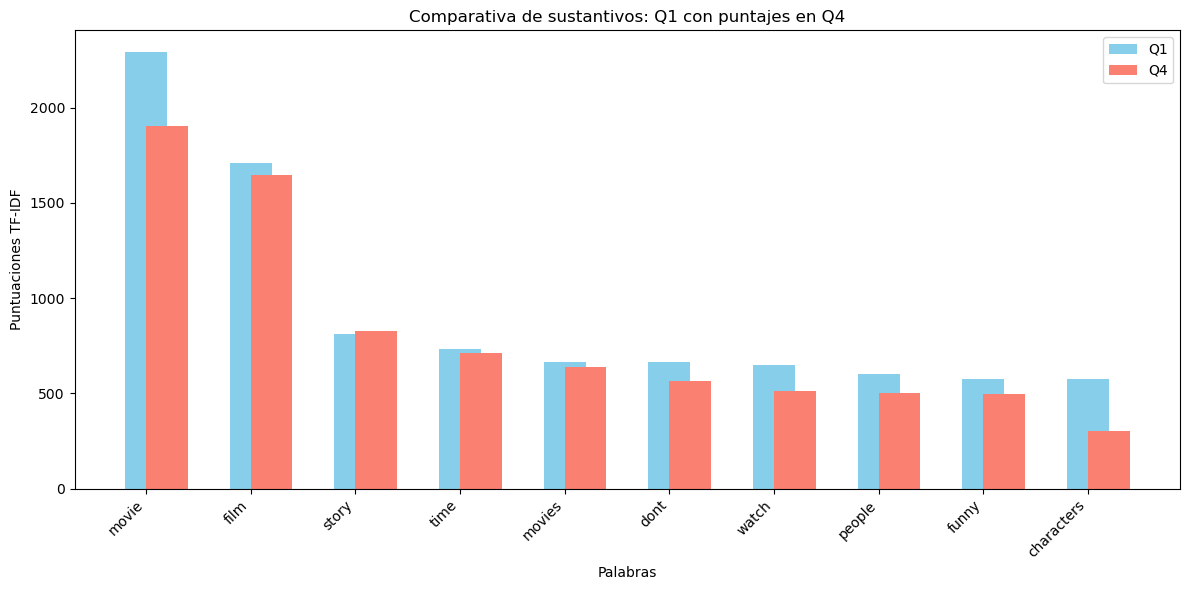

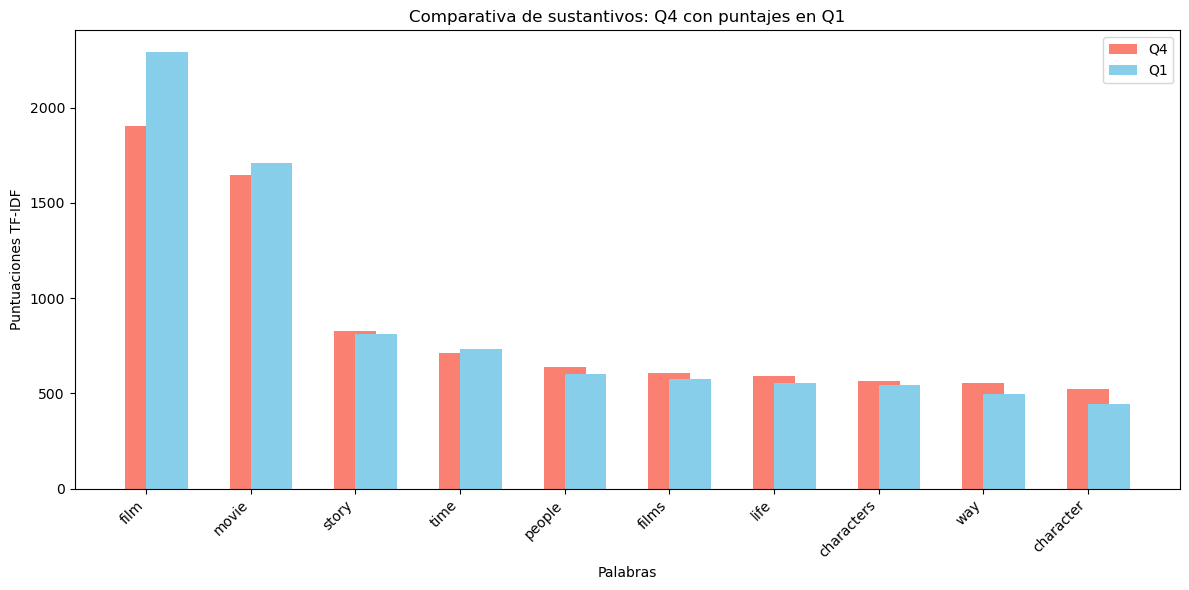

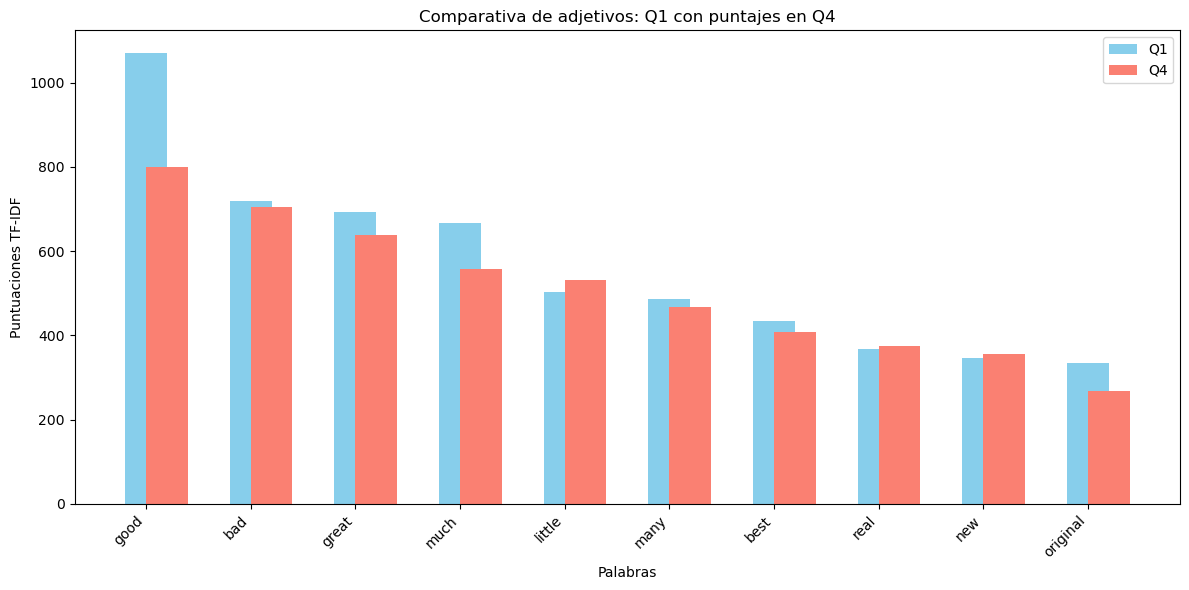

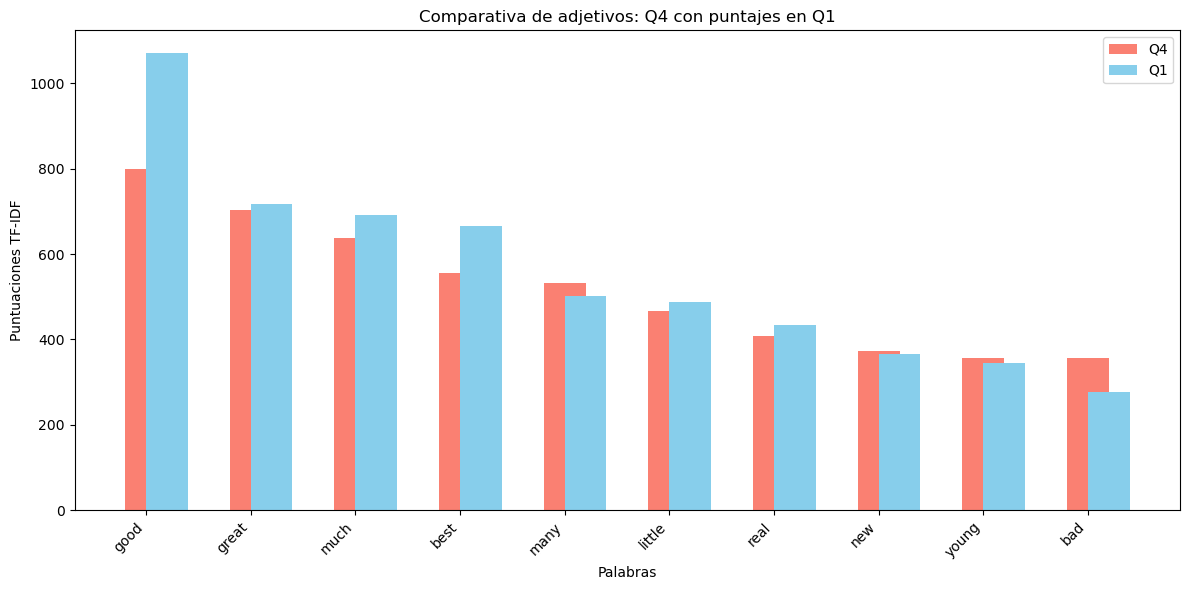

In [23]:
# Esta función filtra las palabras por su tipo: sustantivos o adjetivos
def filtrar_palabras_por_tipo(palabras_relevantes, tipo='NN'):
    """
    Filtra palabras por tipo usando POS tagging.
    - Sustantivos: tipo = 'NN'
    - Adjetivos: tipo = 'JJ'
    """
    return [(word, score) for word, score in palabras_relevantes if pos_tag([word])[0][1].startswith(tipo)]

# Se obtienen las puntuaciones para un conjunto de palabras específico en un cuartil dado
def obtener_puntuaciones_para_palabras(palabras, cuartil, tipo='NN'):
    return [score for word, score in palabras_relevantes_por_cuartil[cuartil] if word in palabras]

# Grafica de comparación de puntuaciones entre dos cuartiles para un tipo de palabras
def graficar_comparativa(palabras, scores1, scores2, cuartil1, cuartil2, titulo, color1, color2):
    plt.figure(figsize=(12, 6))
    x = range(len(palabras))
    plt.bar(x, scores1, width=0.4, label=f'{cuartil1}', align='center', color=color1)
    plt.bar(x, scores2, width=0.4, label=f'{cuartil2}', align='edge', color=color2)
    
    plt.xlabel('Palabras')
    plt.ylabel('Puntuaciones TF-IDF')
    plt.title(titulo)
    plt.xticks(x, palabras, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()




# Parámetros
cuartiles_interes = ['Q1', 'Q4']
num_palabras = 10

colores_cuartiles = ['skyblue', 'salmon', 'lightgreen', 'lightcoral']  # Añadir más colores si tienes más cuartiles

# Filtro de palabras relevantes para Q1 y Q4
palabras_relevantes_sustantivos_Q1 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q1'], 'NN')
palabras_relevantes_sustantivos_Q4 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q4'], 'NN')
palabras_relevantes_adjetivos_Q1 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q1'], 'JJ')
palabras_relevantes_adjetivos_Q4 = filtrar_palabras_por_tipo(palabras_relevantes_por_cuartil['Q4'], 'JJ')

# Generacion de comparativas para sustantivos y adjetivos
for palabras_relevantes, cuartil_base, cuartil_comp, tipo, titulo in [
    (palabras_relevantes_sustantivos_Q1[:num_palabras], 'Q1', 'Q4', 'sustantivos', 'Comparativa de sustantivos: Q1 con puntajes en Q4'),
    (palabras_relevantes_sustantivos_Q4[:num_palabras], 'Q4', 'Q1', 'sustantivos', 'Comparativa de sustantivos: Q4 con puntajes en Q1'),
    (palabras_relevantes_adjetivos_Q1[:num_palabras], 'Q1', 'Q4', 'adjetivos', 'Comparativa de adjetivos: Q1 con puntajes en Q4'),
    (palabras_relevantes_adjetivos_Q4[:num_palabras], 'Q4', 'Q1', 'adjetivos', 'Comparativa de adjetivos: Q4 con puntajes en Q1')
    ]:
    
    palabras = [word for word, score in palabras_relevantes]
    scores_base = [score for word, score in palabras_relevantes]

    scores_comp = obtener_puntuaciones_para_palabras(palabras, cuartil_comp, tipo)

    # Se asignan colores unicos a cada cuartil
    color_base = colores_cuartiles[cuartiles_interes.index(cuartil_base)] 
    color_comp = colores_cuartiles[cuartiles_interes.index(cuartil_comp)] 
    
    graficar_comparativa(palabras, scores_base, scores_comp, cuartil_base, cuartil_comp, titulo, color_base, color_comp)

### Análisis de los 10 sustantivos y adjetivos más discriminantes entre Q1 y Q4

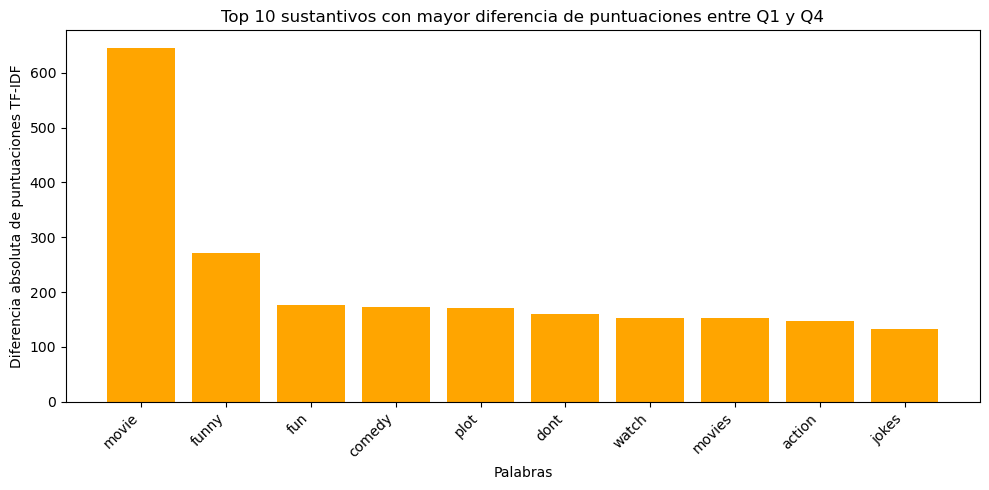

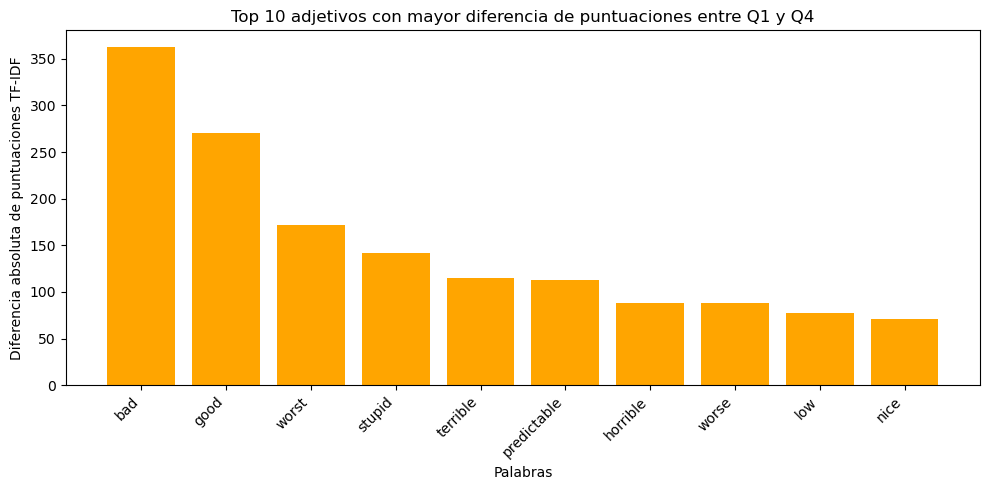

In [24]:
import numpy as np

def obtener_palabras_con_mayor_diferencia(palabras_relevantes_Q1, palabras_relevantes_Q4):
    """
    Calcula las diferencias de puntuación entre palabras en Q1 y Q4 y selecciona las 10 con mayor diferencia.
    """
    # Diccionarios para acceder rápidamente a las puntuaciones de cada palabra
    puntuaciones_Q1 = {word: score for word, score in palabras_relevantes_Q1}
    puntuaciones_Q4 = {word: score for word, score in palabras_relevantes_Q4}
    
    # Intersección de palabras entre Q1 y Q4
    palabras_comunes = set(puntuaciones_Q1.keys()).intersection(set(puntuaciones_Q4.keys()))
    
    # Calcula la diferencia absoluta de puntuaciones y guarda en una lista
    diferencias = [(palabra, puntuaciones_Q1[palabra] - puntuaciones_Q4[palabra]) for palabra in palabras_comunes]
    
    # Ordena por diferencia en orden descendente
    diferencias.sort(key=lambda x: x[1], reverse=True)
    
    # Selecciona las 10 palabras con mayor diferencia
    palabras_mayor_diferencia = diferencias[:10]
    return palabras_mayor_diferencia

# Obtenemos las palabras con mayor diferencia para sustantivos y adjetivos
palabras_mayor_diferencia_sustantivos = obtener_palabras_con_mayor_diferencia(
    palabras_relevantes_sustantivos_Q1, palabras_relevantes_sustantivos_Q4
)
palabras_mayor_diferencia_adjetivos = obtener_palabras_con_mayor_diferencia(
    palabras_relevantes_adjetivos_Q1, palabras_relevantes_adjetivos_Q4
)

# Extraemos palabras y diferencias para graficar
def graficar_diferencias_palabras(palabras_diferencias, tipo_palabra):
    palabras = [word for word, diff in palabras_diferencias]
    diferencias = [diff for word, diff in palabras_diferencias]
    
    plt.figure(figsize=(10, 5))
    plt.bar(palabras, diferencias, color='orange')
    plt.xlabel('Palabras')
    plt.ylabel('Diferencia absoluta de puntuaciones TF-IDF')
    plt.title(f'Top 10 {tipo_palabra} con mayor diferencia de puntuaciones entre Q1 y Q4')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Graficamos las diferencias para sustantivos y adjetivos
graficar_diferencias_palabras(palabras_mayor_diferencia_sustantivos, 'sustantivos')
graficar_diferencias_palabras(palabras_mayor_diferencia_adjetivos, 'adjetivos')

<center>FIN</center>